На примере вебинара Анатолия Карпова рассмотрим такой метод статистического тестирования как бутстрап.
Бустрап представляет собой извлечение с выборочных данных, подвыборок (с повторением), для дальнейшего подсчета на основе этих подвыборок средней, медианы и тд.
Это дает возможность взять доверительный инвервал для медианы, с чем ЦПТ нам помочь не сможет.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')


In [2]:
#Создадим функцию, для проверки гипотез методом бутстрапа

In [14]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "quants": quants,
            "p_value": p_value}


In [15]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})


In [17]:
df

,sample_1,sample_2
0,1206.129738,5217.062841
1,672.811785,1092.106970
2,478.486892,2317.660190
3,1235.674794,67.061993
4,1106.022377,279.745972
...,...,...
995,337.312321,447.445735
996,2668.029291,29.854489
997,507.802272,409.054512
998,3375.812431,2531.970607


  0%|          | 0/1000 [00:00<?, ?it/s]

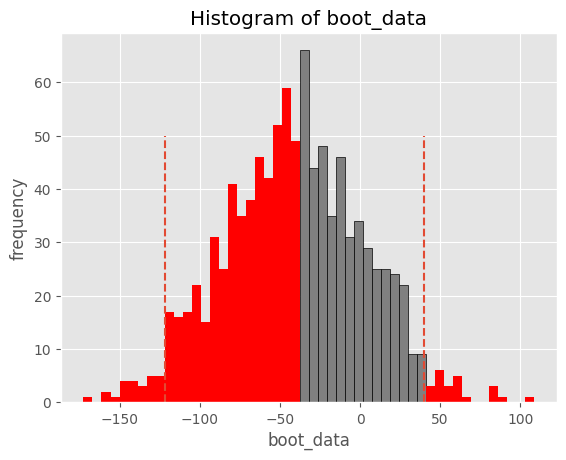

In [16]:
booted_data=get_bootstrap(df.sample_1, df.sample_2)

In [18]:
booted_data['p_value']

0.3418218072445416

In [20]:
booted_data['quants']

,0
0.025,-121.901639
0.975,39.798440


In [24]:
data_ab = pd.read_csv('/content/drive/MyDrive/WORKING/Курсы и проекты/Python/Проекты со сторонних ресурсов/Дата-сеты для проектов /hw_bootstrap.csv', sep=';', decimal=',')

In [25]:
data_ab

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment
...,...,...,...
545,546,10.973929,Control
546,547,10.261074,Control
547,548,8.780090,Control
548,549,11.169078,Control


In [27]:
data_ab.groupby('experimentVariant').agg({'value':'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [28]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [29]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


<Axes: xlabel='experimentVariant', ylabel='value'>

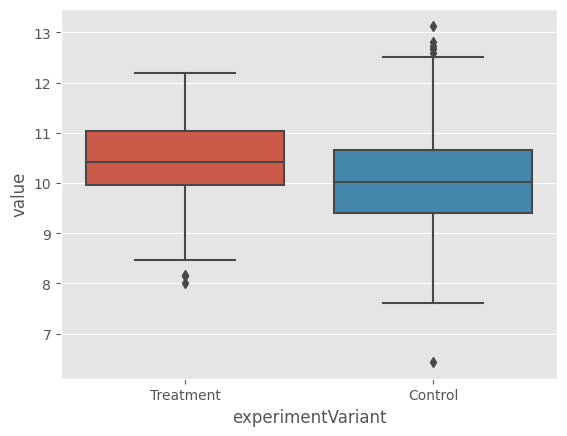

In [31]:
sns.boxplot(x='experimentVariant', y = 'value', data=data_ab)

<ipython-input-32-1d9fa63208e7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)


<Axes: xlabel='value'>

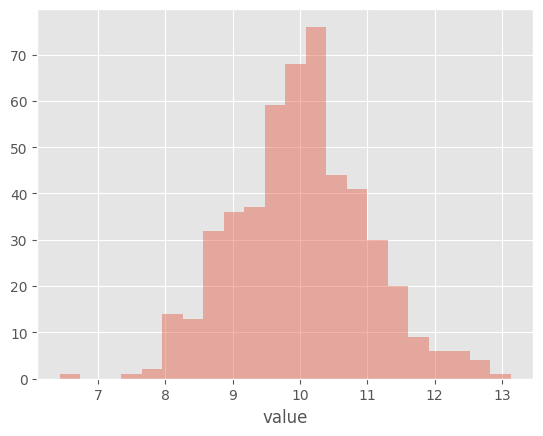

In [32]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

<ipython-input-33-8ba00fb109de>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)


<Axes: xlabel='value'>

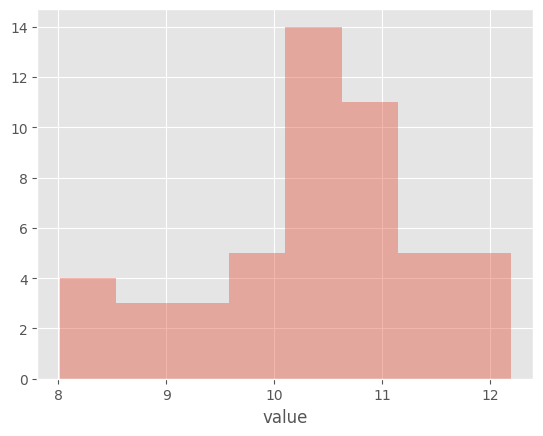

In [33]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [34]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value,
             data_ab[data_ab.experimentVariant == 'Control'].value)


MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)

In [35]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, data_ab[data_ab.experimentVariant == 'Control'].value)

TtestResult(statistic=2.331858965573001, pvalue=0.020069539127355422, df=548.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

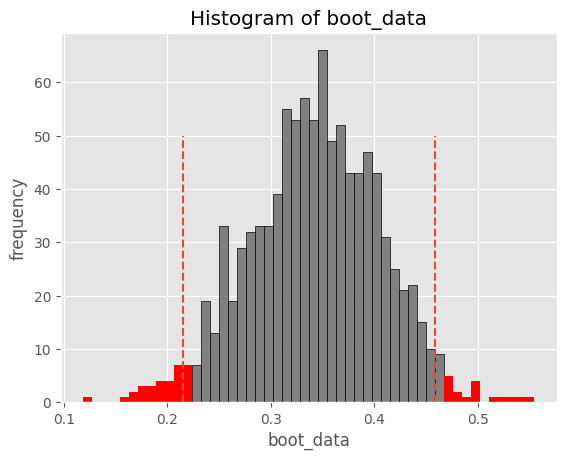

{'boot_data': [0.23852941256848936,
  0.4434143158530117,
  0.35182323766826124,
  0.329984920823738,
  0.43663508777565585,
  0.3915637078010739,
  0.3388336197056269,
  0.3913588531540793,
  0.31142922983135485,
  0.2838311759296787,
  0.2709401909625726,
  0.3296718795583179,
  0.40492570995012567,
  0.4527545778035422,
  0.16019808882237202,
  0.3274006243221521,
  0.38290606804245775,
  0.34262814587556695,
  0.36804337415058586,
  0.3160397884361468,
  0.2764828754585743,
  0.3845684372694179,
  0.4012339327418683,
  0.44882260856587186,
  0.3561512016294979,
  0.3434751856303025,
  0.4087348127016761,
  0.3309369985629198,
  0.3368449357969668,
  0.3208957404845374,
  0.3862555224512718,
  0.3540948061848834,
  0.17684766119175419,
  0.3572699331091023,
  0.33731365567865396,
  0.28161974063729656,
  0.28646705042869147,
  0.41046615289369365,
  0.32617126693921994,
  0.3670644359612609,
  0.311682879291616,
  0.3093025321097185,
  0.3141104806661607,
  0.3066032744577021,
  0.3

In [36]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

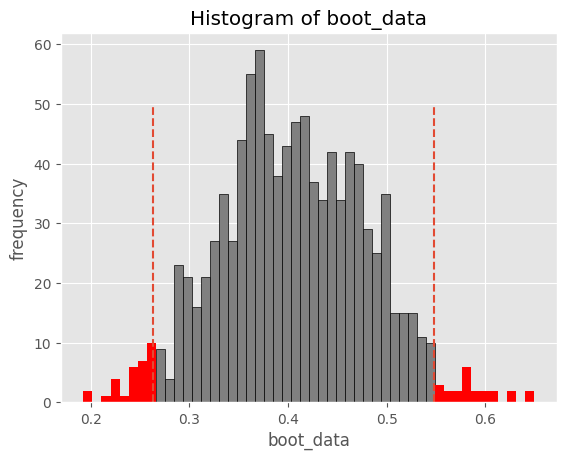

{'boot_data': [0.4973153919669251,
  0.4810685115658595,
  0.2571396019671699,
  0.5345135561563863,
  0.37079558606534935,
  0.3690522105645506,
  0.4100630969871002,
  0.36429303421911996,
  0.4082499050204502,
  0.29670267460343425,
  0.40282778336115044,
  0.3484488910900003,
  0.4099577401220005,
  0.5379657551809993,
  0.34941483542706564,
  0.3791928431372398,
  0.3184259127794,
  0.4641498118170153,
  0.49950983261837045,
  0.362358023371395,
  0.3302289152628859,
  0.5424943835694007,
  0.3348703415168508,
  0.4362289378733504,
  0.3732260872701998,
  0.3532640994679994,
  0.35601469823430065,
  0.28765204737784966,
  0.5011458329078939,
  0.4753535358052652,
  0.4146662158140648,
  0.37260076234530537,
  0.3684909473067446,
  0.37488057234804995,
  0.3270551224248397,
  0.37973925438410383,
  0.4152668110918363,
  0.31613827681675044,
  0.2417337395893142,
  0.4876027251626489,
  0.3228924906066002,
  0.356805668629951,
  0.4210044984818646,
  0.3323133369386202,
  0.38318989

In [37]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)